# Lecture 6: Overfitting and Regularization - 1


Applied Machine Learning 


Professor: __Ramesh Natarajan__ \
Email: **ramesh.natarajan@yu.edu** \
Department of Computer Science \
Stern College and Yeshiva University

Date: Feb 12, 2024



## Acknowledgements

1. The starting point for developing the notebook-based instruction material was the set of notebooks provided by the previous  course instructor__[Prof. Zach Glassman](https://www.linkedin.com/in/zachary-glassman-7088844b/)__.
2. These notebooks have been augmented by similar instruction material taken from many, many other sources, including official documentation from many ML libraries and frameworks. I have adapted and modified the content where needed to make it compatible with student level, orientation and proficiency in this course.
3. The primary addition sources include:
   1. Course content from V. Kuleshov, Cornell Tech __[repo](https://github.com/kuleshov/cornell-cs5785-2020-applied-ml/blob/main/notebooks/lecture1-introduction.ipynb)__.
   2. Book and support material from Hal Daume II, __[A course in Machine Learning](http://ciml.info)__. __[repo](https://github.com/hal3/ciml/)__
   3. Book and support material from A. Geron, __[Hands-On Machine Learning with Scikit-Learn, Keras and Tensorflow (3rd edition)](https://homl.info/er3)__. __[repo](https://github.com/ageron/handson-ml3/blob/main/README.md)__




# Announcements

1. Problem Set 2 is due on Feb 14  
2. Recitations will review Linear Models 2.
3. You should continue  to review and refresh yourself on the mathematical prerequisites for applied machine learning from part 1 for Deisenroth, Faisal and Ong, __[Mathematics for Machine Learning](https://mml-book.github.io/book/mml-book.pdf)__.


# Learning Objectives

+ Understand the concepts of Overfitting/Underfitting and its impact on Model Generalization
+ Understand the concepts of Bias and Variance and their trade-off 
+ Understand the role of regularization in Model Generalization


# Overfitting and Regularization 


<table>
    <td width="40%"><center>
        <img src="./img/Lecture-06/overfitting-creative.png" />      
    </center>
    Generated by Chat-GPT 
     </td>  
    <td>

We have seen overfitting and underfitting before with decision trees, and we have seen that this depends on the **model complexity**, which for a decision tree is roughly the longest path from the root to any leaf node.  

We have seen the model accuracy on the **train set** steadily decreased as the model complexity was increased (to the point when all the examples in the leaf nodes were of the same class, and no further tree splitting was possible).

However, When the leaf nodes had too few examples the corresponding **test set** accuracy was quite poor.  This is due to overfitting, which can happen when the model complexity is high. It can be avoided either by using early stopping to avoid extremely deep trees, or by pruning back the deep trees by absorbing some of the leaf nodes into their parent nodes in the tree (even when doing that makes the train set accuracy worse). 

At the same time, using very short trees, or excessively pruning back the trees also results in the the test set accuracy becoming worse.  This is  due to underfitting.

The issue of model complexity and overfitting/underfitting is common to all supervised models, and in this Lecture we consider how it arises in linear regression models.  

We also connect this issue to the trade-off between Bias versus Variance as a function of model complexity for model predictions.

</td></table> 


# Linear Models - an Example

We generate some synthetic data from a known (nonlinear) function 

$y_i = a + b\tanh{x_i} + \epsilon_i, \; \text{where} \;\epsilon_i \sim \cal{N}(0, \sigma^2)$

In order to successfully model this function we can add features that are polynomial functions of the input variable $x_i$, e.g. $(1, x_i, x_i^2, x_i^3, \ldots, x_i^d)$. 

Then we fit successively increasing orders of polynomial models to this synthetic data. Given that the true function is nonlinear you might expect that you would need a very high polynomial order to fit this data.  However, the fact that 

**Note**:  For future reference, you want to avoid fitting models with very high-order polynomials which are notorious for leading to very poor and unstable models due to collinearity (which we encountered this concept in an earlier lectur).   There are better feature transformations such as orthogonal polynomials or splines which do not have this collinearity issue and should be preferred.

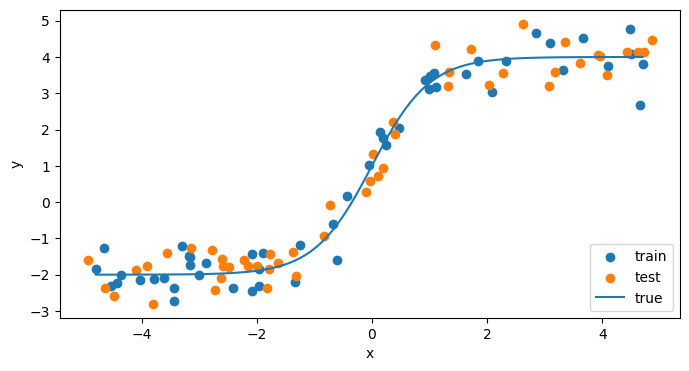

In [13]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 4]
import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

def true_func(x):
    a, b = 1.0, 3.0,
    return a + b * np.tanh(x)
    
def generate_syntheticdata(n, sigma):   
    x = np.random.uniform(-5.0, +5.0,n)
    y =  true_func(x) + np.random.randn(n) * sigma
    return x, y

n_train, n_test, sigma = 50, 50, 0.5
x_train, y_train = generate_syntheticdata(n_train, sigma)
x_test, y_test = generate_syntheticdata(n_test, sigma)

plt.scatter(x_train, y_train, label="train")
plt.scatter(x_test, y_test, label="test")

x_plts = np.linspace(np.min(x_train), np.max(x_train), 100)
y_plts = true_func(x_plts)
plt.plot(x_plts, y_plts, label="true")
plt.xlabel('x')
plt.ylabel('y')
plt.legend( loc='lower right')
plt.show()


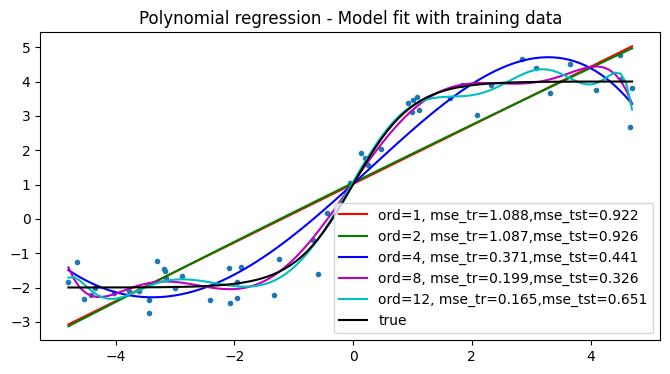

In [14]:

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# plot the model fit for increasing numbers of features
# Note: PolynomialFEatures includes the intercept term by default
plt.plot(x_train, y_train, '.')

def plot_order(n_ord, color):
    ftrs_train = PolynomialFeatures(n_ord).fit_transform(x_train[:, np.newaxis])
    ftrs_test = PolynomialFeatures(n_ord).fit_transform(x_test[:, np.newaxis])
    model = LinearRegression().fit(ftrs_train, y_train) 
    mse_train = np.mean((y_train - model.predict(ftrs_train))**2)
    mse_test = np.mean((y_test - model.predict(ftrs_test))**2)
    x_pts = np.linspace(np.min(x_train), np.max(x_train), 100)
    ftrs_pts = PolynomialFeatures(n_ord).fit_transform(x_pts[:, np.newaxis])
    plt.plot(np.sort(x_pts), model.predict(ftrs_pts), 
               label=f"ord={n_ord}, mse_tr={mse_train:.3f},mse_tst={mse_test:.3f}", 
               color=color)
    

for n_ord, color in zip([1, 2, 4, 8, 12], ['r', 'g', 'b', 'm', 'c']):
    plot_order(n_ord, color)

plt.plot(x_plts, y_plts, c='k', label="true")
plt.legend()
plt.title("Polynomial regression - Model fit with training data")
plt.show()

Let us look at the train set mse versus the test set mse as the order of the polynomial regression n_ord is increased (the standard error of the test set mse is also computed since the sample size for the test set is finite). 

You can see that train set mse decrease with n_ord, whereas the test set mse first decreases then increases. 

1, 1.0880035801052848, 0.9215082834427676, 0.16229111627606416
2, 1.087114418026959, 0.9258377714751134, 0.1628400827508589
3, 0.379345078958429, 0.4246830307440248, 0.07167945221008942
4, 0.37051701742309, 0.44144720133162835, 0.08107938634982369
5, 0.27729144377821124, 0.2685620552377546, 0.046984235927738933
6, 0.27728957769602425, 0.26916942502641156, 0.04702216215289144
7, 0.1991648005775183, 0.3317757708300841, 0.09276972054355583
8, 0.1990021945230968, 0.32610100858880275, 0.08593378758700472
9, 0.187075008941197, 0.2539424826580333, 0.03912239860527396
10, 0.17968828296072117, 0.3333971560006862, 0.08106519064605512
11, 0.1706062678858268, 0.4650526508447576, 0.21245879088741246
12, 0.16511349398436242, 0.6505279333269485, 0.3947566553465856


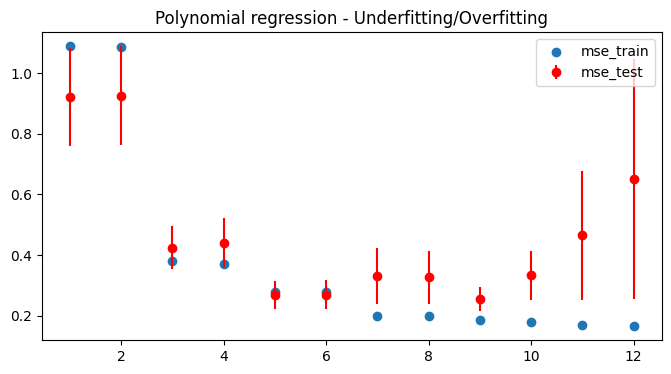

In [15]:
mse_train = []
mse_test = []
mse_test_stderr = []
bias = []
n_ord_max = 13
for ix, n_ord in enumerate(range(1,n_ord_max)) :
    ftrs_train = PolynomialFeatures(n_ord).fit_transform(x_train[:, np.newaxis])
    ftrs_test = PolynomialFeatures(n_ord).fit_transform(x_test[:, np.newaxis])
    model = LinearRegression().fit(ftrs_train, y_train) 
    mse_train.append(np.mean((y_train - model.predict(ftrs_train))**2))
    mse_test.append(np.mean((y_test - model.predict(ftrs_test))**2))
    mse_test_stderr.append(np.std((y_test - model.predict(ftrs_test))**2)/(np.sqrt(x_test.shape[0] - 1)))
    print(f"{n_ord}, {mse_train[ix]}, {mse_test[ix]}, {mse_test_stderr[ix]}")

plt.scatter(np.arange(1,n_ord_max),mse_train,  label="mse_train")
plt.errorbar(np.arange(1,n_ord_max),mse_test, mse_test_stderr, fmt= 'ro', label="mse_test")
plt.legend()
plt.title("Polynomial regression - Underfitting/Overfitting")
plt.show()

# Bias Variance Tradeoff

Consider the data from the model
$y_i = f(x_i) + \epsilon_i$, where $\epsilon_i$ is IID random variable with $\epsilon_i \sim \cal{N}(0, \sigma^2)$ . 

We assume we our model given by $\hat{f}$ leads to the prediction $\hat{y}_i = \hat{f}(x_i)$ at some fixed point $x_i$.

The M.S.E (mean squared error) for the model predictions at a $x_i$ is given by 


\begin{align*}
E\left[(y_i - \hat{y}_i)^2 | x_i\right] 
        & = E\left[ (f(x_i) + \epsilon_i -  E\left[\hat{y}\right] + E\left[\hat{y}\right]- \hat{y}_i)^2 | x_i\right] \\
        & =  E\left[  \epsilon_i^2 \right]  +  E\left[ (f(x_i) - E\left[\hat{y}\right]) | x_i \right]^2 + E\left[(E\left[\hat{y}\right] - \hat{y}_i))^2 | x_i\right] \\
        & = \text{Irreducible Error} + \text{Bias}^2 + \text{Variance}
\end{align*}

We will now show that the the Bias and Variance of a model prediction estimate exhibit the same tradeoff as the underfitting and overfitting as the number of model parameters is increased.  In other words, underfitted models have high Bias and low Variance for model predictions, whereas it is *vice versa* for overfitted model predictions. 

1, [0.92355311], 0.047406550443420195
2, [0.8709057], 0.12673723033641476
3, [0.37675884], 0.06289653715086191
4, [0.35959699], 0.09378132399930254
5, [0.13257029], 0.06655669595699663
6, [0.12345716], 0.0932377194576369
7, [0.04187804], 0.07710586267329965
8, [0.03238683], 0.09817261015255886
9, [0.0115427], 0.1600899108691837
10, [0.00287441], 0.11072178259014036
11, [0.00053875], 0.18120462914855898
12, [0.00253763], 0.2552211966461883


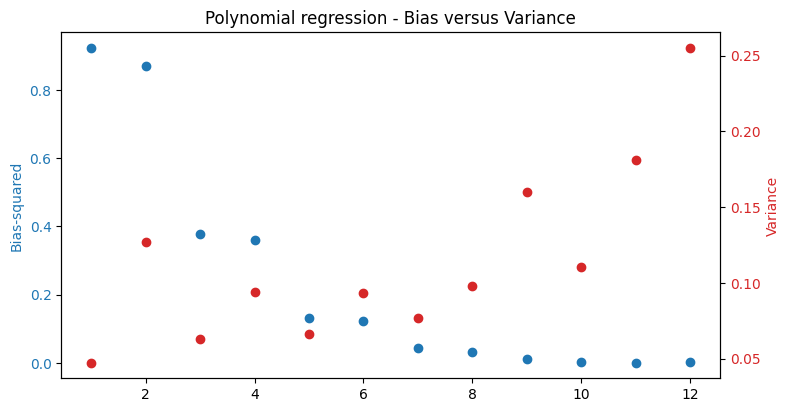

In [16]:
# calculate the predictions at say (x = 0) over 1000 instantiations

n_inst = 500
bias2 = []
variance = []
x_true = np.array([0.5])
y_true = true_func(x_true)

n_ord_max = 13

for ix, n_ord in enumerate(range(1,n_ord_max)) :
    sample = []
    for inst in range(n_inst):
        n_train, sigma = 25, 0.5
        x_train, y_train = generate_syntheticdata(n_train, sigma)
        ftrs_train = PolynomialFeatures(n_ord).fit_transform(x_train[:, np.newaxis])
        ftrs_true = PolynomialFeatures(n_ord).fit_transform(x_true[:, np.newaxis])
        model = LinearRegression().fit(ftrs_train, y_train) 
        sample.append( model.predict(ftrs_true))
    bias2.append((np.mean(sample) - y_true)**2)
    variance.append(np.var(sample))
    print(f"{n_ord}, {bias2[ix]}, {variance[ix]}")


fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_ylabel('Bias-squared', color=color)
ax1.scatter(np.arange(1,n_ord_max),bias2, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Variance', color=color)
ax2.scatter(np.arange(1,n_ord_max),variance, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.title("Polynomial regression - Bias versus Variance")


plt.show()

### How to Avoid Overfitting

- Always use a train/test data split for evaluating the model
- The test data should strictly be for out-of-sample evaluation purpose and should **not** be used for any aspect of the model fitting or model selection
- If test data is not available, use some form of cross-validation to obtain better estimates of out-of-sample model perfomance 

### But wait, there's more.

check out this example of an advanced ML modeling technique.

Some of the advanced ML models have built-in techniques to avoid overfitting (these techniques use a concept called "regularization" that we will cover in the next Lecture.

In [17]:
from sklearn.datasets import fetch_california_housing
bunch = fetch_california_housing()

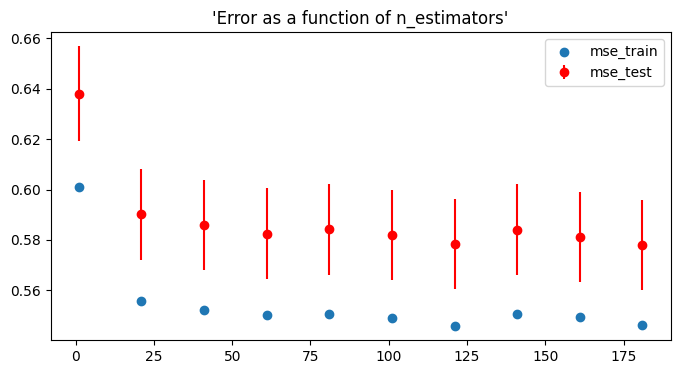

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
X_train, X_test, y_train, y_test = train_test_split(bunch['data'], bunch['target'], test_size=0.2)
res = []
for n_estimators in range(1, 200, 20):
    model = RandomForestRegressor(n_estimators=n_estimators, min_samples_leaf=5, min_samples_split=.1).fit(X_train, y_train)
    res.append({
        'n_estimators': n_estimators,
        'mse_train': np.mean((y_train - model.predict(X_train))**2),
        'mse_test': mean_squared_error(y_test, model.predict(X_test)),
        'mse_test_stderr': np.std((y_test - model.predict(X_test))**2)/(np.sqrt(X_test.shape[0] - 1))
,
    })
df = pd.DataFrame(res)

plt.scatter(df['n_estimators'], df['mse_train'],  label="mse_train")
plt.errorbar(df['n_estimators'], df['mse_test'], df['mse_test_stderr'], fmt= 'ro', label="mse_test")
plt.legend()
plt.title("'Error as a function of n_estimators'")
plt.show()

# Summary

- Overfitting is related to the model complexity, that is the number of parameters in the model
- As the model complexity is increased the training set accuracy metrics improve, but the test set accuracy metrics initially decrease then incresase.
- Overfitted models have low bias but high variance
- Underfitted models have high bias but low variance
- The mean square error (MSE) of the model can be decomposed in the form Bias$^2$ + Variance
- More sophisticated models employ a number of methods to control overfitting (regularization, model averaging etc.) TBD